In [1]:
import numpy as np
from numpy import random
import scipy as sp

# import scanpy for dimensionality reduction and plotting
import anndata as ad
from scanpy.api.tl import umap
from scanpy.api import pp

# set viridis as the default color map
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
mpl.rcParams['image.cmap'] = 'viridis'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# simulation
import tree
import simulation as sim
import sim_utils as sut
import count_model as cmod
import tree_utils as tu

Set random seed for reproducibility

In [4]:
rseed = 42
np.random.seed(rseed)

We are going to use a simple branching trajectory for this example:

In [5]:
top = [["A", "B"], ["A", "C"]]

Define the tree

In [6]:
branches = np.unique(np.array(top).flatten())
time = {b: 100 for b in branches}
G = 400
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=1, modules=25)

In [7]:
vel = {}
for b in branches:
    vel[b] = np.zeros(time[b])

We want a process that is slow in the beginning of branch A, fast in its middle, slow close to the branch point between A,B, and C, slower at the middle of B and C, then faster again towards the end of B and C. We can use a sine to imitate that:

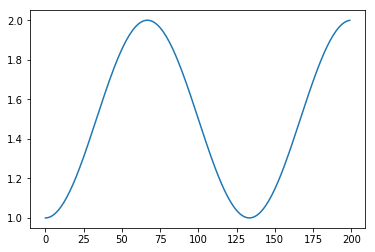

In [8]:
fig, ax = plt.subplots()
a = np.sin(np.arange(-0.5*np.pi, 2.5*np.pi,  step=3*np.pi/t.get_max_time()))/2 + 1.5
ax.plot(a)

Assign the velocity of the first hundred steps to branch A and the last hundred steps to branches B and C:

In [9]:
br_time = t.branch_times()

start, end = br_time["A"]
vel["A"] = np.copy(a[start:(end + 1)])

start, end = br_time["B"]
vel["B"] = np.copy(a[start:(end + 1)])
vel["C"] = np.copy(a[start:(end + 1)])

Set this as the velocity of the differentiation:

In [10]:
t.set_velocity(vel)

Simulate the change of gene expression without any constraints:

In [11]:
uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

/home/npapado/Documents/repos/prosstt/dev/simulation.py:154: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  "No argument 'a' specified in kwargs: using gamma and a=0.04", UserWarning)
/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Choose the variance parameters for the genes:

In [12]:
alpha = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

Simulate data from the linear differentiation

In [13]:
X1, labs1, brns1, scalings1 = sim.sample_density(t, 1000, alpha=alpha, beta=beta)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

If the velocity was set correctly, we expect many cells in the beginning (low differentiation speed), few cells close to the branch point (pseudotime=100), more cells just before the middle of branches B and C and less cells the closer we get to the end of the differentiation. The velocity and the density of cells move in an anticorrelated manner:

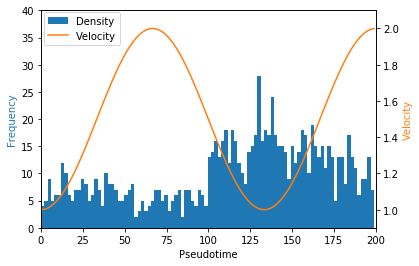

In [14]:
fig, host = plt.subplots(nrows=1, ncols=1)

par1 = host.twinx()

host.set_xlim(0, 200)
host.set_ylim(0, 40)
par1.set_ylim(0.9, 2.1)

host.set_xlabel("Pseudotime")
host.set_ylabel("Frequency")
par1.set_ylabel("Velocity")

color1 = u'#1f77b4'
color2 = u'#ff7f0e'
h = host.hist(labs1, bins=100, color=color1, label="Density")
p2, = par1.plot(a, color=color2, label="Velocity")

fig.legend(bbox_to_anchor=(0.29, 0.9))

# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

host.yaxis.label.set_color(color1)
par1.yaxis.label.set_color(color2)

Calculate and plot the UMAP embedding of the differentiation, colored by branch and (true) pseudotime. The branching region and the ends of branches B and C (blue, green) are sparsely populated, while the beginning of branch A (red) and the middles of branches B and C have a higher density of cells.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


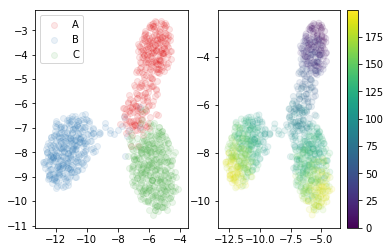

In [15]:
data1 = ad.AnnData(np.log(X1+1))
pp.neighbors(data1, use_rep='X', n_neighbors=200)
umap(data1)
dm1 = data1.obsm["X_umap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
for i, branch in enumerate(t.branches):
    selected = (brns1 == branch)
    ax[0].scatter(dm1[selected, 0], dm1[selected, 1], alpha=0.1, label=branch, c=cm.Set1(i))
ax[0].legend()

pt = ax[1].scatter(dm1[:, 0], dm1[:, 1], c=labs1, visible=False)
ax[1].scatter(dm1[:, 0], dm1[:, 1], c=labs1, alpha=0.1)
cb = fig.colorbar(pt)